In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

START = 2018
END = 2025

In [2]:
# RAG+LLM 추출 내용 load
def get_extracted_data(start : int = START, end : int = END):
    papers = {}
    models = {}
    metrics = {}

    for i in range(start, end+1):
        papers[f"{i}"] = pd.read_csv(f"./res/{i}/papers.csv")
        models[f"{i}"] = pd.read_csv(f"./res/{i}/models.csv")
        metrics[f"{i}"] = pd.read_csv(f"./res/{i}/metrics.csv")

    return papers, models, metrics

# 메타데이터 불러오는 헬퍼 함수
def get_metadata(start : int = START, end : int = END) -> dict[str, pd.DataFrame]:
    metadatas = {}

    for i in range(start, end+1):
        root = f"./res/{i}/metadata"
        metadatas[f"{i}"] = pd.concat(
            [
                pd.read_csv(os.path.join(root, file_name)).assign(keyword=file_name[:-4])
                for file_name in os.listdir(root)
                if file_name.endswith(".csv")
            ],
            axis=0,
            ignore_index=True
        )
        metadatas[f"{i}"] = metadatas[f"{i}"].dropna(subset=["Document Title"])
        metadatas[f"{i}"]["Abstract"] = metadatas[f"{i}"]["Abstract"].astype(str)
        
    return metadatas


metadatas = get_metadata()
papers, models, metrics = get_extracted_data()


# 시간대별 라벨 수 확인

In [3]:
task_effiMentioned_anual = {}

for i in range(START, END+1):
    task_effiMentioned_anual[str(i)] = pd.merge(papers[str(i)], models[str(i)], on="paper_id").drop_duplicates(subset=["paper_id"])[["task", "efficiency_mentioned"]]

/var/folders/1n/3_46_bbx39l4m34jz8q8xbmr0000gn/T/ipykernel_94153/4252131759.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  task_ratio_pivot = (task_stats['sum'] / counts * 100).fillna(0)


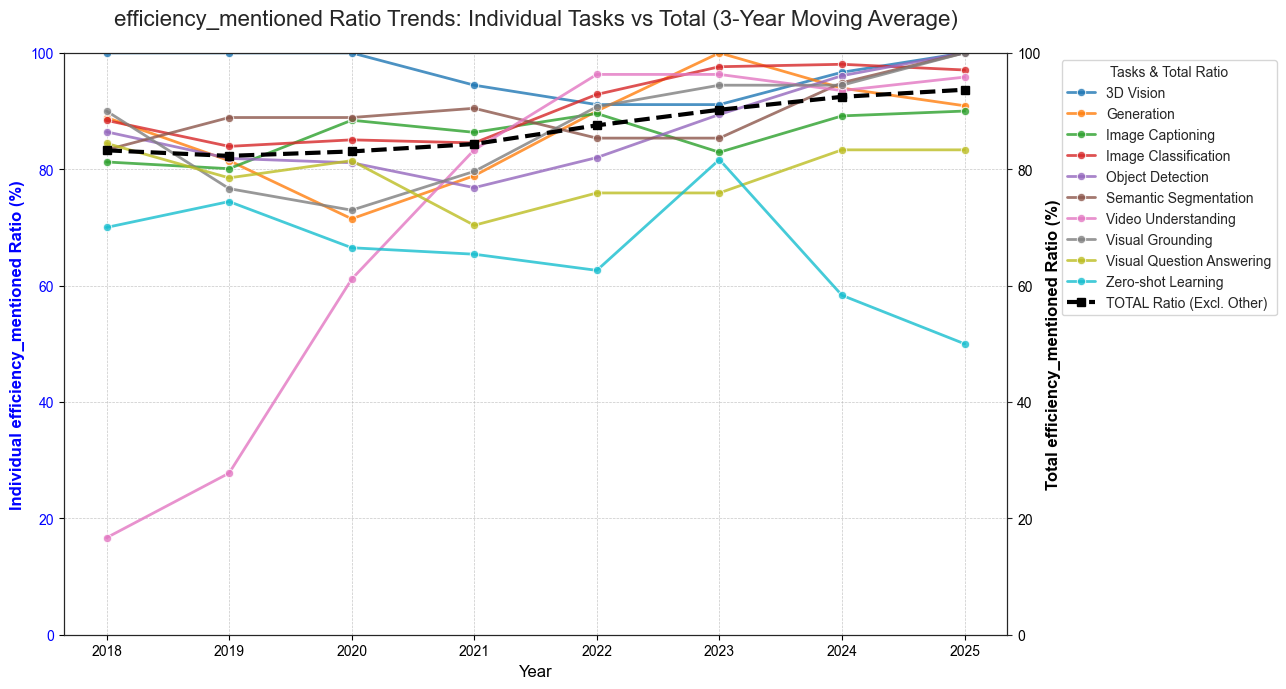

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_task_mentioned_ratio_trend(data_dict, tag : str, top_k=5, window_size=1):
    """
    각 태스크 및 전체 데이터의 효율성 언급 비율(%) 추이를 시각화
    """
    all_data = []
    for year, df in data_dict.items():
        temp_df = df.copy()
        temp_df['year'] = int(year)
        all_data.append(temp_df)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    
    combined_df = combined_df[combined_df['task'] != 'Other'].copy()
    years = sorted(combined_df['year'].unique())
    
    total_stats = combined_df.groupby('year')[tag].agg(['sum', 'count'])
    total_ratio = (total_stats['sum'] / total_stats['count'] * 100).reindex(years, fill_value=0)
    
    top_tasks = combined_df['task'].value_counts().nlargest(top_k).index
    
    # 5. 태스크별 비율 계산
    task_stats = combined_df[combined_df['task'].isin(top_tasks)].groupby(['year', 'task'])[tag].agg(['sum', 'count']).unstack(fill_value=0)
    
    counts = task_stats['count'].replace(0, pd.NA)
    task_ratio_pivot = (task_stats['sum'] / counts * 100).fillna(0)
    
    title_suffix = ''
    if window_size > 1:
        task_ratio_pivot = task_ratio_pivot.rolling(window=window_size, min_periods=1, center=True).mean()
        total_ratio = total_ratio.rolling(window=window_size, min_periods=1, center=True).mean()
        title_suffix = f' ({window_size}-Year Moving Average)'

    plot_df = task_ratio_pivot.reset_index().melt(id_vars='year', var_name='task', value_name='ratio')

    fig, ax1 = plt.subplots(figsize=(13, 7))
    sns.set_style("white")

    sns.lineplot(
        data=plot_df, x='year', y='ratio', hue='task', 
        marker='o', linewidth=2, ax=ax1, alpha=0.8
    )
    ax1.set_ylabel(f'Individual {tag} Ratio (%)', fontsize=12, fontweight='bold', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    ax1.set_ylim(0, 100)

    ax2 = ax1.twinx()
    ax2.plot(
        total_ratio.index, total_ratio.values, 
        color='black', linestyle='--', linewidth=3, marker='s', label='TOTAL Ratio (Excl. Other)'
    )
    ax2.set_ylabel(f'Total {tag} Ratio (%)', fontsize=12, fontweight='bold', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.grid(False)
    ax2.set_ylim(0, 100)

    plt.title(f'{tag} Ratio Trends: Individual Tasks vs Total{title_suffix}', fontsize=16, pad=20)
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_xticks(years)

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, title='Tasks & Total Ratio', 
               bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    
plot_task_mentioned_ratio_trend(task_effiMentioned_anual, "efficiency_mentioned", top_k=10, window_size=3)

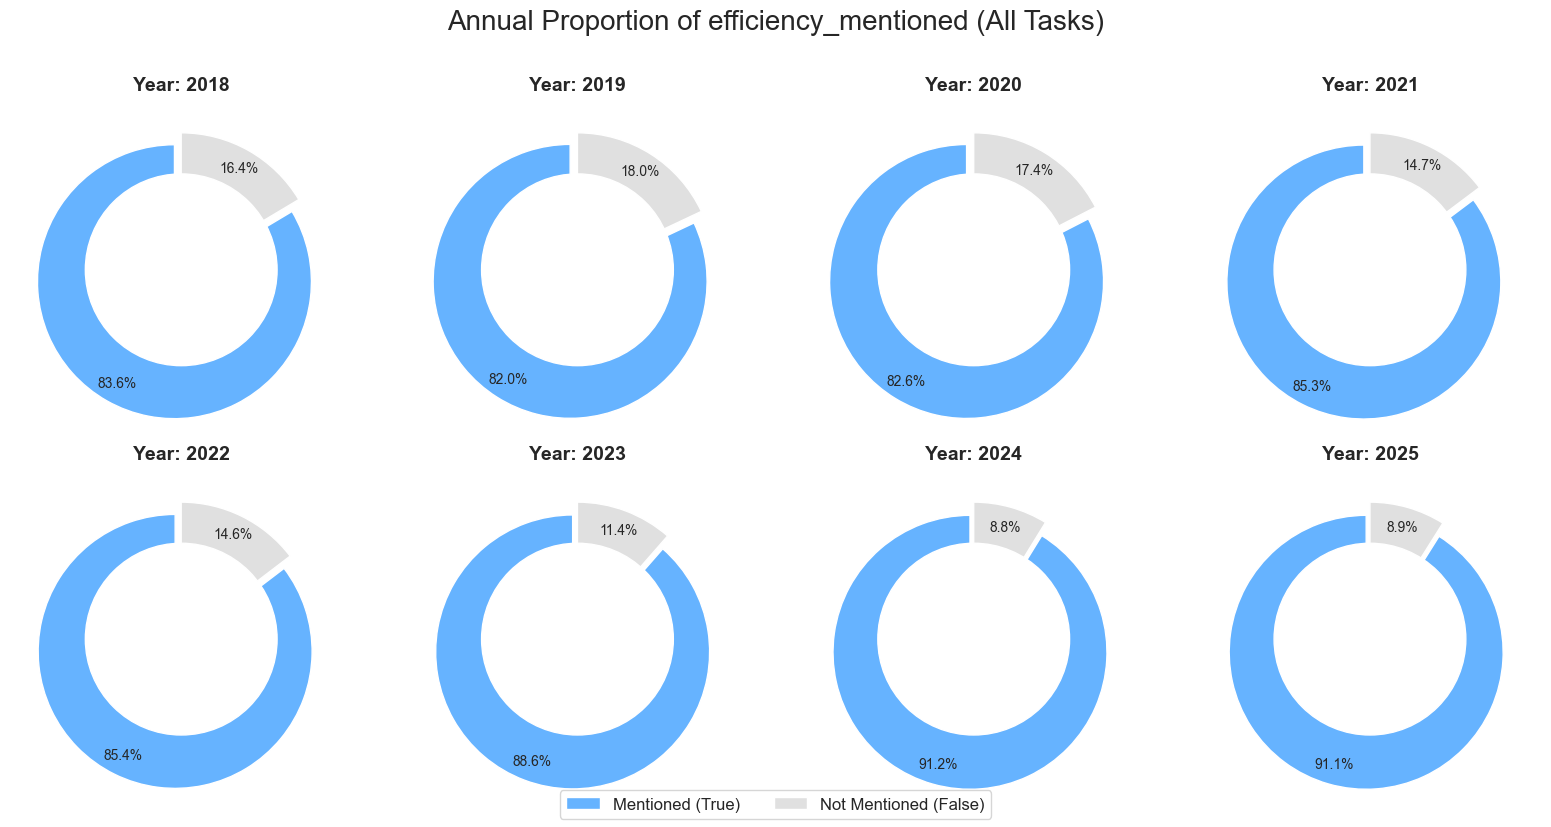

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_mentioned_ratio_pie(data_dict, tag : str):
    """
    연도별 전체 데이터에서 mentioned가 차지하는 비율을 원형 차트로 시각화
    """
    years = sorted(data_dict.keys())
    num_years = len(years)
    
    cols = 4
    rows = math.ceil(num_years / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    axes = axes.flatten() # 2차원 배열을 1차원으로 변환하여 반복문 사용 용이하게 함

    colors = ['#ff9999', '#66b3ff'] # False, True 순서
    
    for i, year in enumerate(years):
        df = data_dict[year]
        

        counts = df[tag].value_counts().sort_index() # False(0), True(1) 순 정렬
        

        labels = [f"Mentioned ({counts.get(True, 0)})", f"Not Mentioned ({counts.get(False, 0)})"]
        sizes = [counts.get(True, 0), counts.get(False, 0)]
        

        axes[i].pie(
            sizes, 
            labels=None, # 범례가 따로 있으므로 라벨은 제거
            autopct='%1.1f%%', # 퍼센트 표시
            startangle=90, 
            colors=['#66b3ff', '#e0e0e0'], # True(파랑), False(회색)
            pctdistance=0.85,
            explode=(0.1, 0) if counts.get(True, 0) > 0 else (0, 0) # 언급된 부분 살짝 분리
        )
        

        centre_circle = plt.Circle((0,0), 0.70, fc='white')
        axes[i].add_artist(centre_circle)
        
        axes[i].set_title(f"Year: {year}", fontsize=14, fontweight='bold')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.figlegend(['Mentioned (True)', 'Not Mentioned (False)'], loc='lower center', ncol=2, fontsize=12)
    
    plt.suptitle(f'Annual Proportion of {tag} (All Tasks)', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()
    
plot_mentioned_ratio_pie(task_effiMentioned_anual, "efficiency_mentioned")

In [6]:
task_envMentioned_anual = {}

for i in range(START, END+1):
    task_envMentioned_anual[str(i)] = pd.merge(papers[str(i)], models[str(i)], on="paper_id").drop_duplicates(subset=["paper_id"])[["task", "environment_mentioned"]]

/var/folders/1n/3_46_bbx39l4m34jz8q8xbmr0000gn/T/ipykernel_94153/4252131759.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  task_ratio_pivot = (task_stats['sum'] / counts * 100).fillna(0)


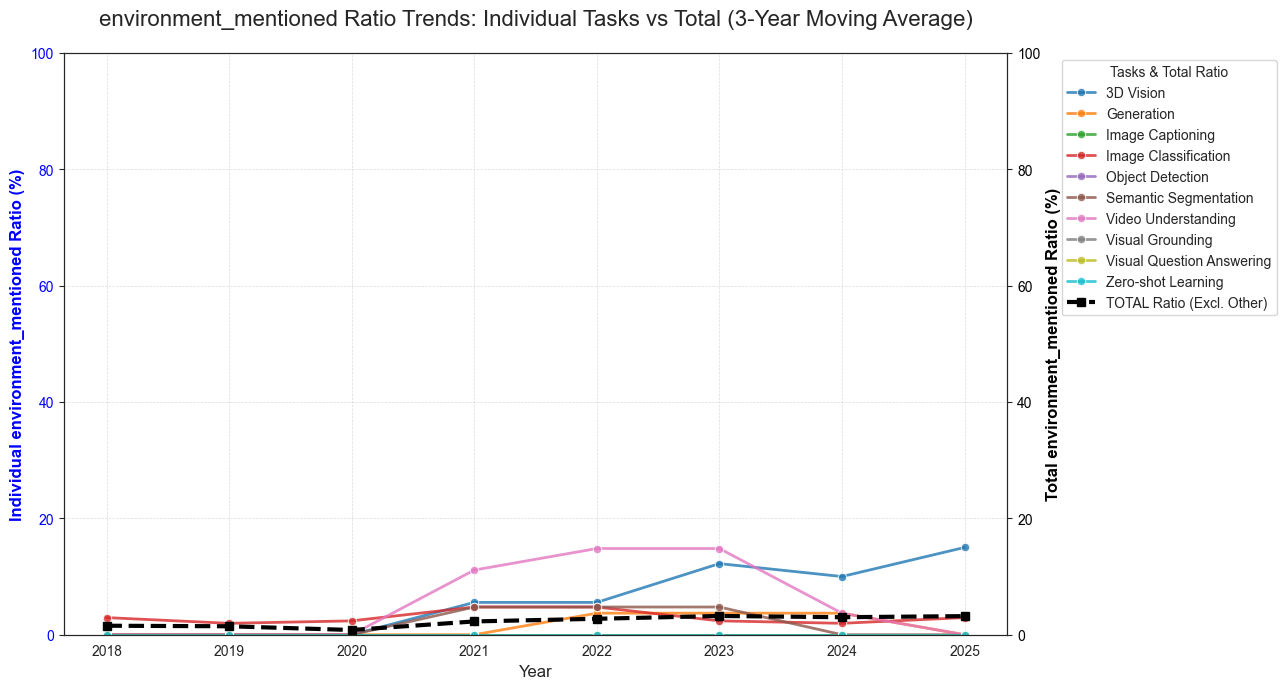

In [7]:
plot_task_mentioned_ratio_trend(task_envMentioned_anual, "environment_mentioned", top_k=10, window_size=3)

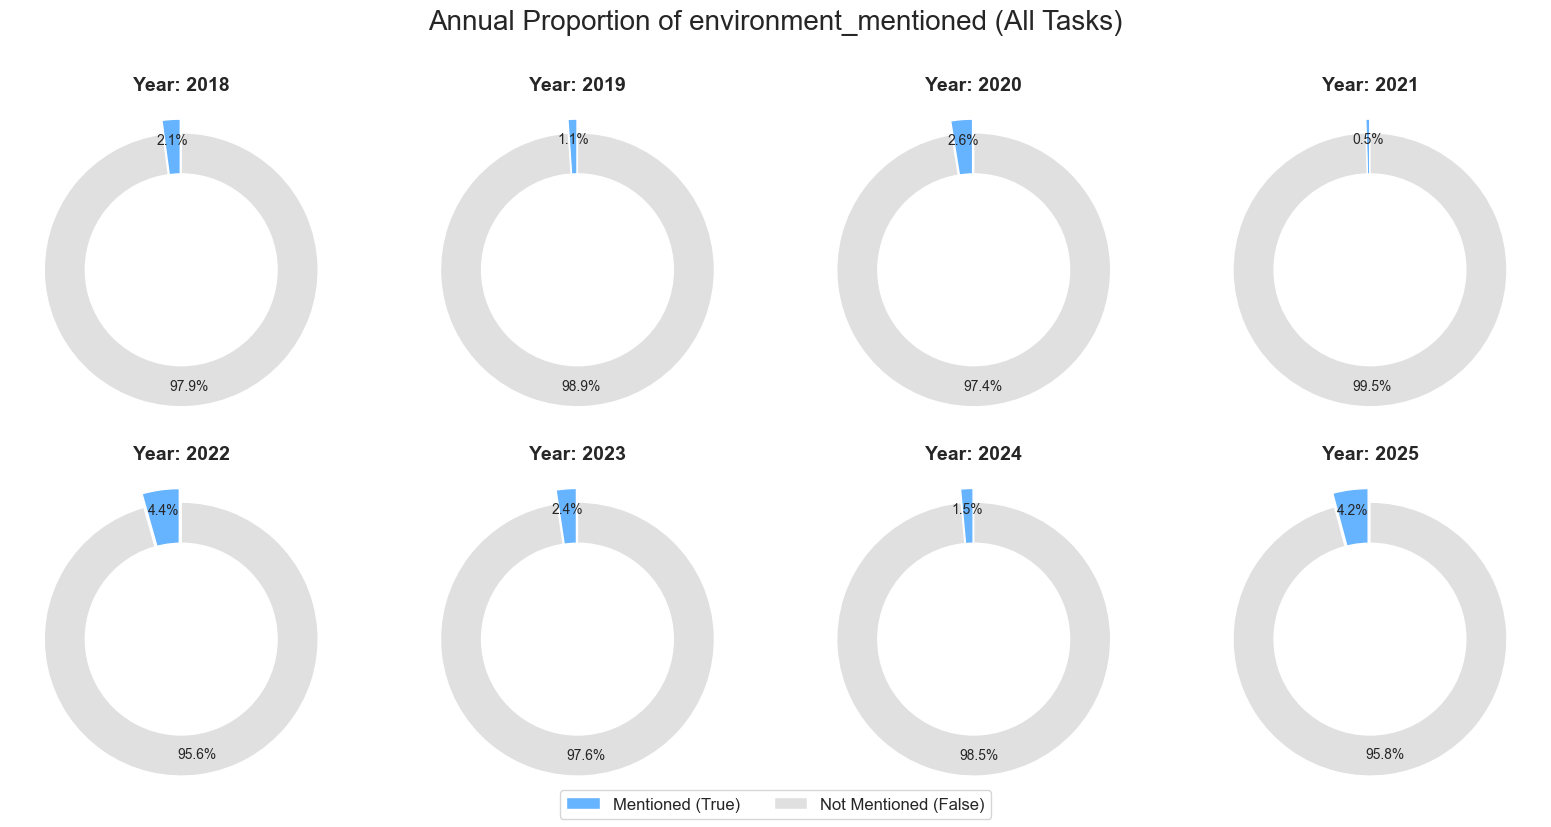

In [8]:
plot_mentioned_ratio_pie(task_envMentioned_anual, "environment_mentioned")

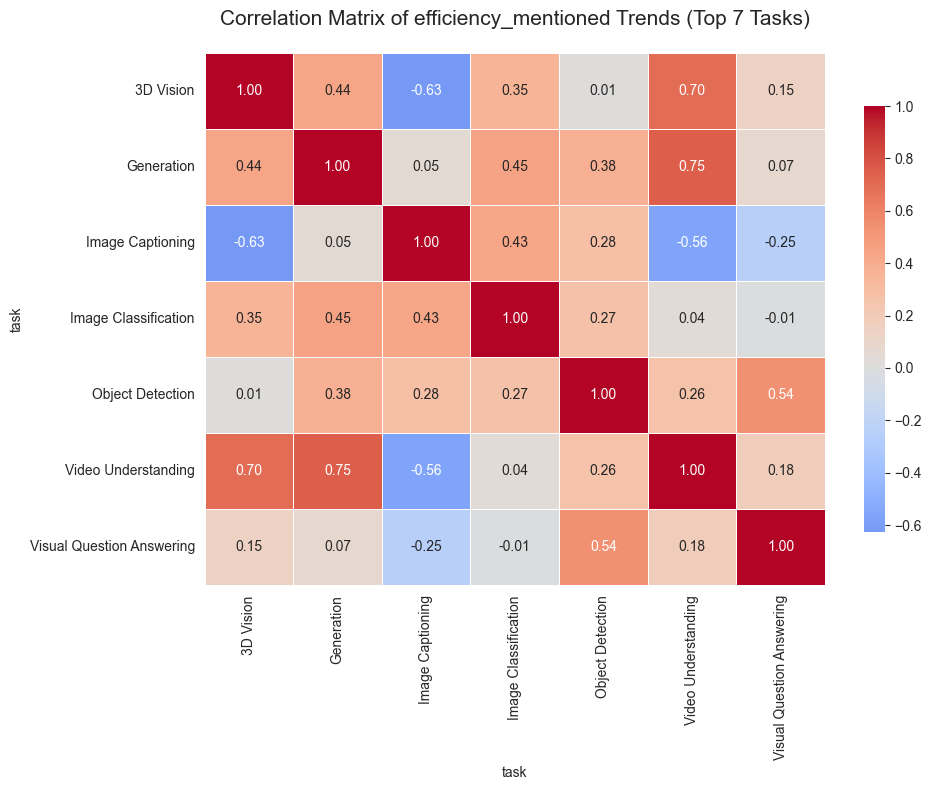

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_task_correlation_heatmap(data_dict, tag : str, top_k=10):
    """
    태스크별 연도별 언급 빈도 간의 상관관계를 히트맵으로 시각화
    
    Args:
        data_dict (dict): 연도별 DataFrame이 담긴 딕셔너리
        top_k (int): 상관관계를 분석할 상위 태스크 개수 (너무 많으면 가독성이 떨어짐)
    """
    all_data = []
    for year, df in data_dict.items():
        temp_df = df.copy()
        temp_df['year'] = int(year)
        all_data.append(temp_df)
    
    combined_df = pd.concat(all_data, ignore_index=True)
    filtered_df = combined_df[
        (combined_df['task'] != 'Other') & 
        (combined_df[tag] == True)
    ]

    top_tasks = filtered_df['task'].value_counts().nlargest(top_k).index
    final_df = filtered_df[filtered_df['task'].isin(top_tasks)]

    matrix_df = final_df.groupby(['year', 'task']).size().unstack(fill_value=0)

    corr_matrix = matrix_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix, 
        annot=True,          # 수치 표시
        fmt=".2f",           # 소수점 둘째자리까지
        cmap='coolwarm',     # 색상 맵 (빨강: 양의 상관관계, 파랑: 음의 상관관계)
        center=0,            # 0을 기준으로 색상 배분
        linewidths=.5,       # 칸 사이 구분선
        cbar_kws={"shrink": .8}
    )

    plt.title(f'Correlation Matrix of {tag} Trends (Top {top_k} Tasks)', fontsize=15, pad=20)
    plt.tight_layout()
    plt.show()

plot_task_correlation_heatmap(task_effiMentioned_anual, "efficiency_mentioned", top_k=7)

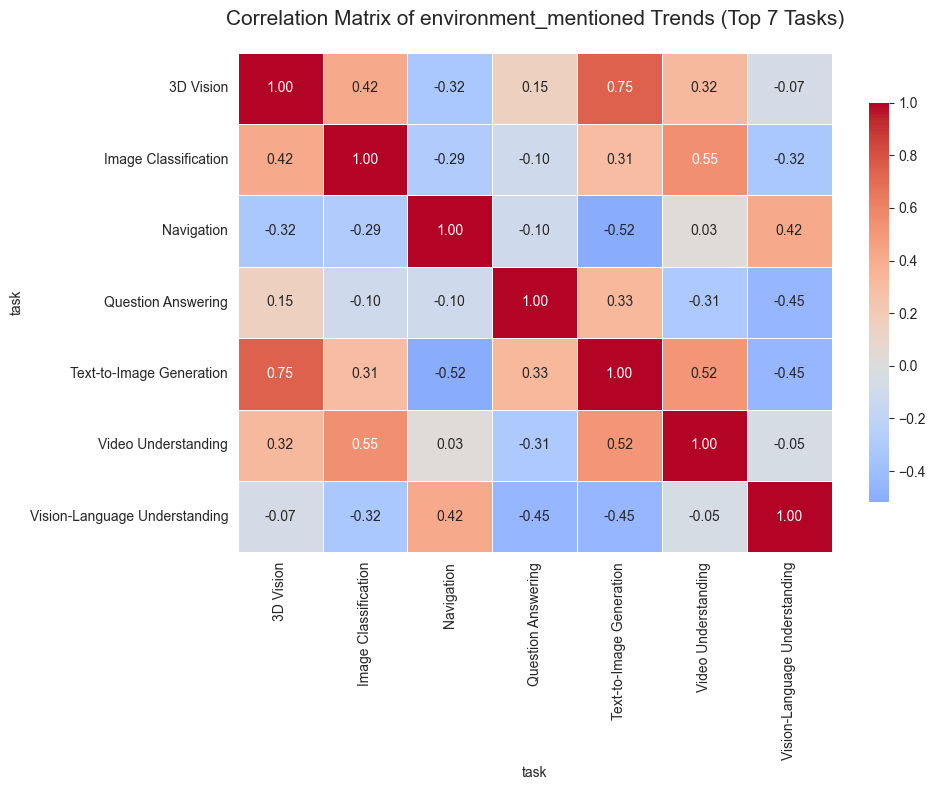

In [10]:
plot_task_correlation_heatmap(task_envMentioned_anual, "environment_mentioned", top_k=7)